In [1]:
from typing import List

import pandas as pd

from src.constants import LYS_BONDS, LIP_BONDS, OVA_BONDS, BSA_BONDS, LYS, LIP, BSA, OVA
from src.fragment import Fragment
from src.precursor import Precursor
from src.utils import load_fragment_matches, load_precursor_matches
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx

import itertools

from src.variant import Variant

PROTEIN = "OVA"
SEGMENTS = 3
BREAKS = 2

KIND = "AT"
ERROR = 15
CODE = None

# Visualising
CMAP = plt.get_cmap("PiYG")
CYSTEINES = []
TRUE_BONDS = []


def get_cysteines(sequence):
    return [i for i, res in enumerate(sequence) if res == "C"]


if PROTEIN == "LYS":
    CYSTEINES = get_cysteines(LYS)
    TRUE_BONDS = LYS_BONDS
elif PROTEIN == "LIP":
    CYSTEINES = get_cysteines(LIP)
    TRUE_BONDS = LIP_BONDS
elif PROTEIN == "OVA":
    CYSTEINES = get_cysteines(OVA)
    TRUE_BONDS = OVA_BONDS
elif PROTEIN == "BSA":
    CYSTEINES = get_cysteines(BSA)
    TRUE_BONDS = BSA_BONDS

CYSTEINES

[10, 29, 72, 119, 366, 381]

In [2]:
precursor_matches = load_precursor_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, error=ERROR, code=CODE
)
precursor_matches[:3]

[{'scan': <scan.Scan at 0x10c320d60>,
  'precursor': Precursor(sequence='VASMASEKMK', mass=1099.5491270128098, mz=366.5163756709366, segments=[(19, 21)], residue_ranges=[(218, 228)], cys_bond_count=0, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949)], error_ppm=1.61994158660139)},
 {'scan': <scan.Scan at 0x11eb5e580>,
  'precursor': Precursor(sequence='VASMASEKMK', mass=1098.5413019807397, mz=549.2706509903699, segments=[(19, 21)], residue_ranges=[(218, 228)], cys_bond_count=0, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949)], error_ppm=2.0766689938784535)},
 {'scan': <scan.Scan at 0x10c3b3640>,
  'precursor': Precursor(sequence='VASMASEKMK', mass=1115.54402701281, mz=371.84800900427, segments=[(19, 21)], residue_ranges=[(218, 228)], cys_bond_count=0, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949), Modification(description='Met Oxidation', mass=15.9949)], err

In [3]:
fragment_matches = load_fragment_matches(
    protein=PROTEIN, kind=KIND, segments=SEGMENTS, breaks=BREAKS, error=ERROR, code=CODE
)
fragment_matches[:3]

[{'scan': <scan.Scan at 0x10c394dc0>,
  'precursor': Precursor(sequence='VASMASEKMK', mass=1099.5491270128098, mz=366.5163756709366, segments=[(19, 21)], residue_ranges=[(218, 228)], cys_bond_count=0, alkylation_count=0, modifications=[Modification(description='Met Oxidation', mass=15.9949)], error_ppm=1.61994158660139),
  'variant': <src.variant.Variant at 0x120a5efa0>,
  'variant_count': 1,
  'fragment': Fragment(id=72, sequence='VASMA', residue_ranges=[(218, 223)], intensity=25954.171875, intensity_ratio=0.005475684288019038, mass=476.21787983174, target_mass=475.21303766793, mz=476.21787983174, target_mz=476.2208627, charge=1, break_count=1, error_ppm=6.276946857243898, modifications=(Modification(description='Met Oxidation', mass=15.9949),), connected_bonds=[], disconnected_cys=[])},
 {'scan': <scan.Scan at 0x10c3b3dc0>,
  'precursor': Precursor(sequence='VASMASEKMK', mass=1099.5491270128098, mz=366.5163756709366, segments=[(19, 21)], residue_ranges=[(218, 228)], cys_bond_count=0,

In [6]:
records = [
    fm["scan"].to_dict()
    | fm["precursor"].to_dict()
    | fm["variant"].to_dict()
    | fm["fragment"].to_dict()
    | {"variant_count": fm["variant_count"]}
    for fm in fragment_matches
]

records[:3]

[{'scan_id': 863,
  'scan_nth_in_order': 55,
  'scan_time': 363.1775098 second,
  'scan_total_intensity': 4739895.602050781,
  'prec_charge': 3,
  'prec_sequence': 'VASMASEKMK',
  'prec_segment_count': 1,
  'prec_tryptide_ranges': [(19, 21)],
  'prec_residue_ranges': [(218, 228)],
  'prec_max_mc_count': 1,
  'prec_mc': [1],
  'prec_cys_bond_count': 0,
  'prec_mass': 1099.5491270128098,
  'prec_mz': 366.5163756709366,
  'prec_error': 1.61994158660139,
  'prec_alkylation_count': 0,
  'prec_mods': ['Met Oxidation'],
  'var_bonds': [],
  'frag_id': 72,
  'frag_sequence': 'VASMA',
  'frag_residue_ranges': [(218, 223)],
  'frag_charge': 1,
  'frag_mass': 476.21787983174,
  'frag_mz': 476.21787983174,
  'frag_break_count': 1,
  'frag_error_ppm': 6.276946857243898,
  'frag_mods': ['Met Oxidation'],
  'frag_connected_bonds': [],
  'frag_disconnected_cys': [],
  'frag_interesting_disconnected_cys': [],
  'frag_intensity': 25954.171875,
  'frag_intensity_ratio': 0.005475684288019038,
  'target_ma

In [8]:
df = pd.DataFrame(records)


def stringify(df, column):
    df[column] = [" + ".join([str(r) for r in rs]) for rs in df[column]]


for c in [
    "prec_tryptide_ranges",
    "prec_residue_ranges",
    "prec_mods",
    "prec_mc",
    "var_bonds",
    "frag_residue_ranges",
    "frag_mods",
    "frag_connected_bonds",
    "frag_disconnected_cys",
    "frag_interesting_disconnected_cys",
]:
    stringify(df, c)

df

,scan_id,scan_nth_in_order,scan_time,scan_total_intensity,prec_charge,prec_sequence,prec_segment_count,prec_tryptide_ranges,prec_residue_ranges,prec_max_mc_count,...,frag_error_ppm,frag_mods,frag_connected_bonds,frag_disconnected_cys,frag_interesting_disconnected_cys,frag_intensity,frag_intensity_ratio,target_mass,target_mz,variant_count
0,863,55,363.177510,4.739896e+06,3,VASMASEKMK,1,"(19, 21)","(218, 228)",1,...,6.276947,Met Oxidation,,,,25954.171875,0.005476,475.213038,476.220863,1
1,863,55,363.177510,4.739896e+06,3,VASMASEKMK,1,"(19, 21)","(218, 228)",1,...,6.064052,Met Oxidation + -H2O (neutral loss),,,,45613.417969,0.009623,979.452613,490.734131,1
2,863,55,363.177510,4.739896e+06,3,VASMASEKMK,1,"(19, 21)","(218, 228)",1,...,7.212472,Met Oxidation,,,,27275.337891,0.005754,997.464432,499.740041,1
3,863,55,363.177510,4.739896e+06,3,VASMASEKMK,1,"(19, 21)","(218, 228)",1,...,1.104446,,,,,55770.710938,0.011766,218.072272,219.080097,1
4,863,55,363.177510,4.739896e+06,3,VASMASEKMK,1,"(19, 21)","(218, 228)",1,...,2.001771,Met Oxidation,,,,49506.398438,0.010445,234.066945,235.074770,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,11168,8932,1644.438399,6.223317e+04,3,ELKVHHANENIFYCPIAIMSALAMVYLGAKDSTR+CVSP,2,"(1, 4) + (33, 34)","(16, 50) + (381, 385)",2,...,11.143946,-H2O (neutral loss),,,,2104.570557,0.033818,587.309269,196.777581,1
1214,11235,8985,1653.593213,3.599418e+04,3,DEDTQAMPFRVTEQESKPVQMMYQIGLFRVASMASEK,1,"(17, 20)","(189, 226)",2,...,11.154668,,,,,1900.764282,0.052808,1160.585169,387.869548,1
1215,11656,9328,1711.175614,7.291893e+04,3,DEDTQAMPFRVTEQESKPVQMMYQIGLFRVASMASEK,1,"(17, 20)","(189, 226)",2,...,5.528773,-H2O (neutral loss),,,,2882.504395,0.039530,1444.676305,482.566593,1
1216,11656,9328,1711.175614,7.291893e+04,3,DEDTQAMPFRVTEQESKPVQMMYQIGLFRVASMASEK,1,"(17, 20)","(189, 226)",2,...,11.818301,-H2O (neutral loss),,,,2680.371826,0.036758,859.418609,287.480695,1


In [9]:
csv_path = (
    "../out/csv/fragment_matches_{}_{}_segments={}_breaks={}_error={}ppm{}.csv".format(
        PROTEIN, KIND, SEGMENTS, BREAKS, ERROR, "" if CODE is None else f"_{CODE}"
    )
)
print(f"Saving to {csv_path}")
df.to_csv(csv_path, index_label="id", sep=";")

Saving to ../out/csv/fragment_matches_OVA_AT_segments=3_breaks=2_error=15ppm.csv


In [14]:

def visualise_ideal(cysteines: List[int]):
    g = nx.complete_graph(reversed(cysteines[3:] + cysteines[:3]))
    plt.figure(figsize=(5, 5), dpi=200)

    edges = [tuple(sorted(e)) for e in g.edges()]
    scores = [e in TRUE_BONDS for e in edges]
    scores_normalized = [
        abs(s - min(scores)) / abs(max(scores) - min(scores)) for s in scores
    ]
    colors = [CMAP(s) for s in scores_normalized]

    return nx.draw_circular(
        g,
        with_labels=True,
        node_size=1200,
        node_color="#E7DBB7",
        edge_color=colors,
        width=3,
    )


def compute_prec_probabilities(fragment_matches):
    tryptide_count = Counter()
    for match in precursor_matches:
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                tryptide_count[t] += 1

    total = sum(tryptide_count.values())
    tryptide_probability = {}
    for t, count in tryptide_count.items():
        tryptide_probability[t] = count / total

    precursor_probability = []
    for match in fragment_matches:
        probability = 1
        precursor: Precursor = match["precursor"]
        for sb, se in precursor.segments:
            for t in range(sb, se):
                probability *= tryptide_probability[t]
        precursor_probability.append(probability)

    return precursor_probability


def calculate_scores(fragment_matches, probs, cysteines: List[int]):
    possible_bonds = list(itertools.combinations(cysteines, 2))
    positive_evidence = {b: 0 for b in possible_bonds}
    negative_evidence = {b: 0 for b in possible_bonds}
    alkylation_score = {c: 0 for c in cysteines}

    DIRECT_POS_WEIGHT = 1
    NEG_WEIGHT = 1
    INDIRECT_POS_WEIGHT = 1
    NEG_ALK_WEIGHT = 1

    for match, prob in zip(fragment_matches, probs):
        fragment: Fragment = match["fragment"]

        variant: Variant = match["variant"]
        if not all(b in TRUE_BONDS for b in variant.bonds):
            continue

        P = (1 / match["variant_count"]) ** 2
        cys_in_bonds = []

        for b in fragment.connected_bonds:
            positive_evidence[b] += P * DIRECT_POS_WEIGHT
            cys_in_bonds += list(b)
            for x, y in negative_evidence:
                if (x, y) != b and (x in b or y in b):
                    # We're looking at A<–>B, every other bond with A or B is decreased
                    negative_evidence[(x, y)] += P * NEG_WEIGHT

        for c in fragment.disconnected_cys:
            # TODO: Check if only interesting matter
            cys_in_bonds.append(c)
            for b in positive_evidence:
                if c in b:
                    positive_evidence[b] += P * INDIRECT_POS_WEIGHT

        if len(cys_in_bonds) != len(set(cys_in_bonds)):
            print(match["scan"].id)
            # assert len(cys_in_bonds) == len(set(cys_in_bonds))

        for c in cysteines:
            if c not in cys_in_bonds and any(
                b <= c < e for b, e in fragment.residue_ranges
            ):
                alkylation_score[c] += P * NEG_ALK_WEIGHT

    return positive_evidence, negative_evidence, alkylation_score


def intersects(t1, t2):
    return t1[0] in t2 or t1[1] in t2


def score(e, positive, negative, alkylation):
    # alkylated = alkylation[e[0]] + alkylation[e[1]]
    # if positive[e] > alkylated:
    #     return positive[e] / (alkylated + 0.1)
    # else:
    #     return -alkylated / (positive[e] + 0.1)
    return positive[e]


def normalize(x, xs):
    return abs(x - min(xs)) / abs(max(xs) - min(xs))


def visualise(
    cysteines: List[int], positive_evidence, negative_evidence, alkylation_score
):
    nodes = list(reversed(cysteines[3:] + cysteines[:3]))
    g = nx.complete_graph(nodes)
    plt.figure(figsize=(5, 5), dpi=200)

    edges = [tuple(sorted(e)) for e in g.edges()]
    scores = [
        (e, score(e, positive_evidence, negative_evidence, alkylation_score))
        for e in edges
    ]

    scores_normalized = [normalize(s, [n for f, n in scores]) for e, s in scores]
    edge_colors = [CMAP(s) for s in scores_normalized]

    node_scores = [(alkylation_score[n]) for n in nodes]
    node_scores_normalized = [
        abs(s - min(positive_evidence.values()))
        / abs(max(positive_evidence.values()) - min(positive_evidence.values()))
        for s in node_scores
    ]
    node_colors = [CMAP(s) for s in node_scores_normalized]

    return nx.draw_circular(
        g,
        with_labels=True,
        node_size=1200,
        node_color="#E7DBB7",
        linewidths=3,
        edgecolors=node_colors,
        edge_color=edge_colors,
        width=3,
    )


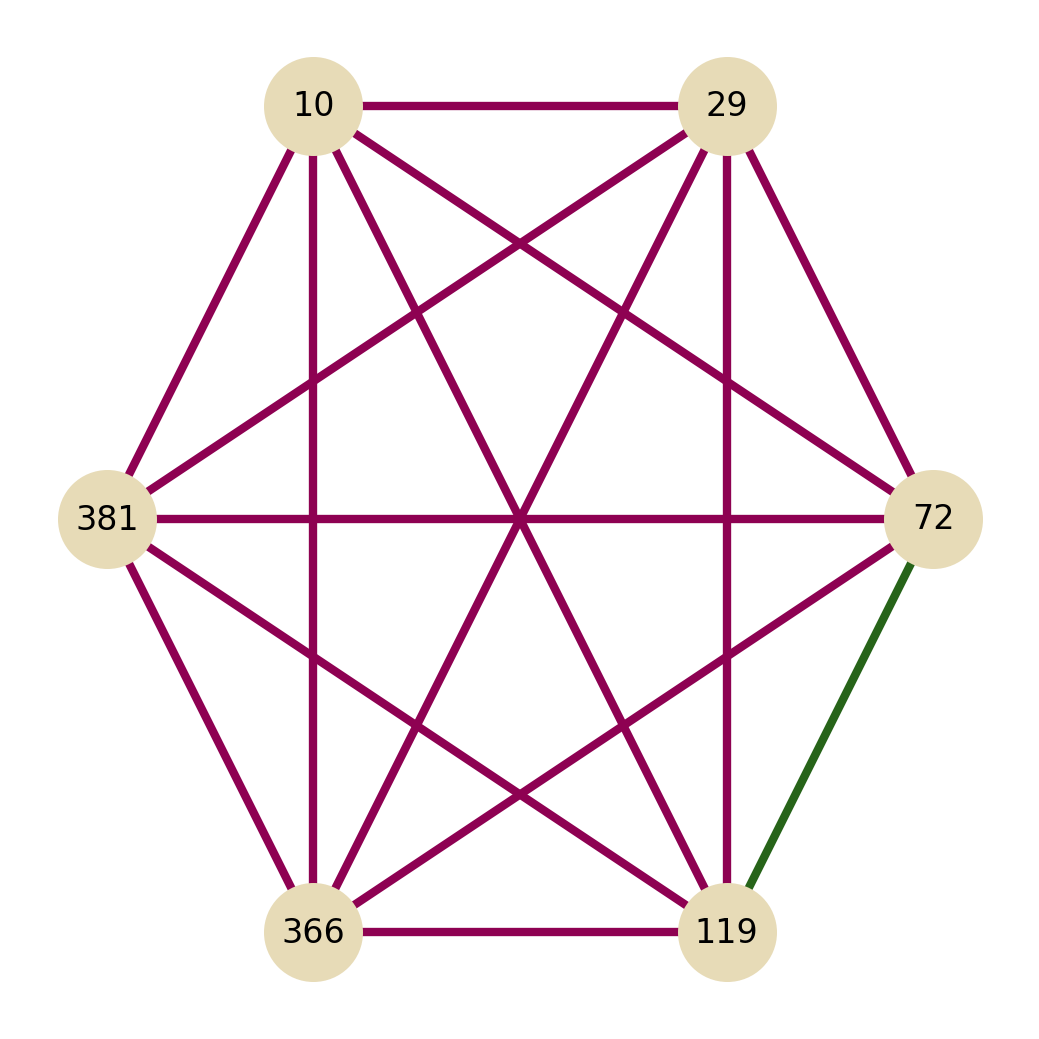

In [15]:
visualise_ideal(CYSTEINES)

In [16]:
prec_probs = compute_prec_probabilities(fragment_matches)
prec_probs[:3]

[0.0013756659970303082, 0.0013756659970303082, 0.0013756659970303082]

In [31]:
pos, neg, alk = calculate_scores(fragment_matches, prec_probs, CYSTEINES)
visualise(CYSTEINES, pos, neg, alk)

ZeroDivisionError: division by zero

<Figure size 1000x1000 with 0 Axes>

In [32]:
pos

{(10, 29): 0,
 (10, 72): 0,
 (10, 119): 0,
 (10, 366): 0,
 (10, 381): 0,
 (29, 72): 0,
 (29, 119): 0,
 (29, 366): 0,
 (29, 381): 0,
 (72, 119): 0,
 (72, 366): 0,
 (72, 381): 0,
 (119, 366): 0,
 (119, 381): 0,
 (366, 381): 0}

In [34]:
for pm in precursor_matches:
    p: Precursor = pm["precursor"]
    if any(b <= 72 < e for b, e in p.residue_ranges) and any(
        b <= 119 < e for b, e in p.residue_ranges
    ):
        print(p.to_dict())

{'prec_sequence': 'GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAKDSTR+LPGFGDSIEAQCGTSVNVHSSLR+YPILPEYLQCVKELYR', 'prec_segment_count': 3, 'prec_tryptide_ranges': [(0, 4), (7, 8), (10, 12)], 'prec_residue_ranges': [(0, 50), (61, 84), (110, 126)], 'prec_max_mc_count': 3, 'prec_mc': [3, 0, 1], 'prec_cys_bond_count': 2, 'prec_mass': 9926.86418214936, 'prec_mz': 1985.372836429872, 'prec_error': 1.274856718039514, 'prec_alkylation_count': 0, 'prec_mods': ['Met Oxidation', 'Met Oxidation']}
{'prec_sequence': 'GSIGAASMEFCFDVFKELKVHHANENIFYCPIAIMSALAMVYLGAKDSTR+FDKLPGFGDSIEAQCGTSVNVHSSLR+YPILPEYLQCVKELYRGGLEPINFQTAADQAR', 'prec_segment_count': 3, 'prec_tryptide_ranges': [(0, 4), (6, 8), (10, 13)], 'prec_residue_ranges': [(0, 50), (58, 84), (110, 142)], 'prec_max_mc_count': 3, 'prec_mc': [3, 1, 2], 'prec_cys_bond_count': 2, 'prec_mass': 11986.884309699128, 'prec_mz': 1997.8140516165213, 'prec_error': 6.278999173459721, 'prec_alkylation_count': 0, 'prec_mods': ['Met Oxidation', 'Met Oxidation']}


In [12]:
precursor_matches[0]["precursor"].residue_ranges

[(65, 73)]